In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [41]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [42]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'PISA'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
batch='PISA'

In [43]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA.npy', 
                                   allow_pickle=True).item()

# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+'_'+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12_noshock']
subjects = list(dict_results_across_mice.keys())

In [44]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

In [45]:
dict_results_across_mice.keys()

dict_keys(['BL13_noshock', 'BL4_demonstrator', 'BL9_demonstrator', 'BL2_observer', 'BL17_demonstrator', 'BL22_demonstrator', 'BL1_noshock', 'BL20_noshock', 'BL19_noshock', 'BL16_observer', 'BL15_noshock', 'BL10_observer', 'BL11_noshock', 'BL6_demonstrator', 'BL7_noshock', 'BL14_demonstrator', 'BL3_demonstrator', 'BL5_observer', 'BL18_observer', 'BL8_observer', 'BL21_observer'])

In [21]:
# # remove one group
# removed = []
# for subject in dict_results_across_mice.keys():
#     if subject.split('_')[0] in ['BL'+str(i) for i in range(9,17)]:
#         removed.append(subject)
# for key in removed:
#     del dict_results_across_mice[key]

In [46]:
# dict_results_across_mice.keys()

# Format data for task PLS

In [47]:
data_ncells = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='n_cells')
data_energy = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='energy')
data_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                    batch=batch, table='density')
data_relative_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                             batch=batch, table='relative_density')
data_ncells.dropna(inplace=True, axis=1)
data_energy.dropna(inplace=True, axis=1)
data_density.dropna(inplace=True, axis=1)
data_relative_density.dropna(inplace=True, axis=1)
data_ncells.to_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy.to_csv('./results_pls/'+batch+'_energy.csv')
data_density.to_csv('./results_pls/'+batch+'_density.csv')
data_relative_density.to_csv('./results_pls/'+batch+'_relative_density.csv')

# Format data for hierarchy plotting

In [49]:
df_levels = upls.create_df_levels(volumes)

# Apply task PLS

In [50]:
%%bash
python area_pls.py -i results_pls/PISA_n_cells.csv -o './results_pls/PISA_ncells'

In [51]:
%%bash
python area_pls.py -i results_pls/PISA_energy.csv -o './results_pls/PISA_energy'

In [52]:
%%bash
python area_pls.py -i results_pls/PISA_density.csv -o './results_pls/PISA_density'

In [53]:
%%bash
python area_pls.py -i results_pls/PISA_relative_density.csv -o './results_pls/PISA_relative_density'

# PLS ncells

In [54]:
contrasts = pd.read_csv('./results_pls/PISA_ncells_contrasts.csv')
saliences = pd.read_csv('./results_pls/PISA_ncells_saliences.csv')
contrasts = contrasts.rename(columns={"group_noshock": "noshock", 
                                      "group_demonstrator": "demonstrator", 
                                      "group_observer":"observer"})

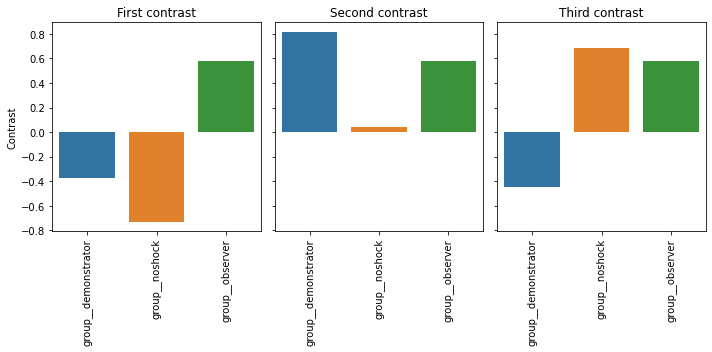

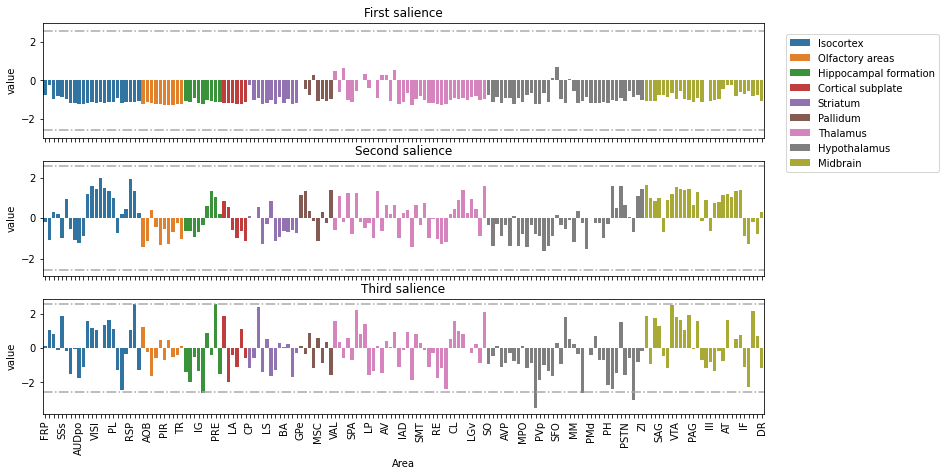

In [55]:
upls.plot_panel_contrasts(batch=batch, variable='ncells')
upls.plot_panel_saliences(batch=batch, variable='ncells', df_levels=df_levels)

# PLS energy

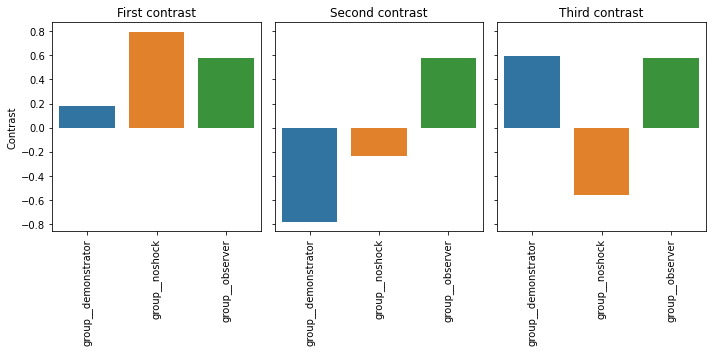

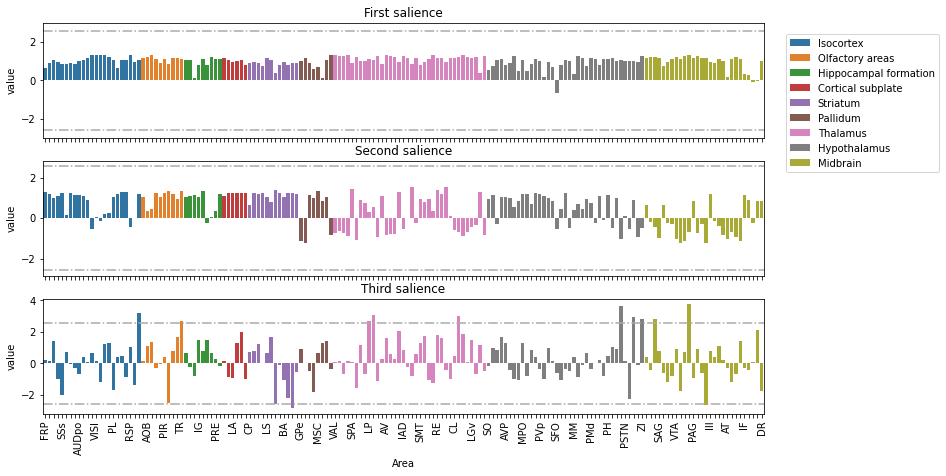

In [56]:
upls.plot_panel_contrasts(batch=batch, variable='energy')
upls.plot_panel_saliences(batch=batch, variable='energy', df_levels=df_levels)

# PLS density

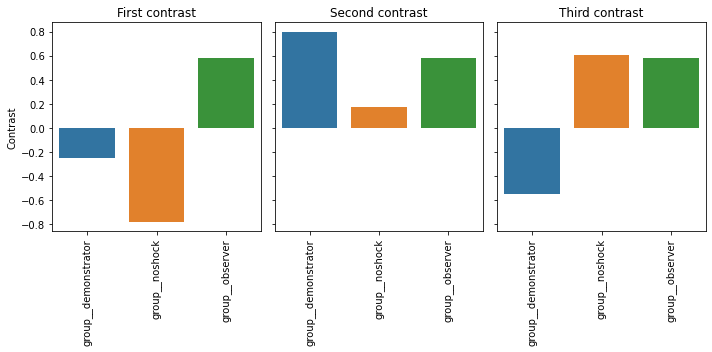

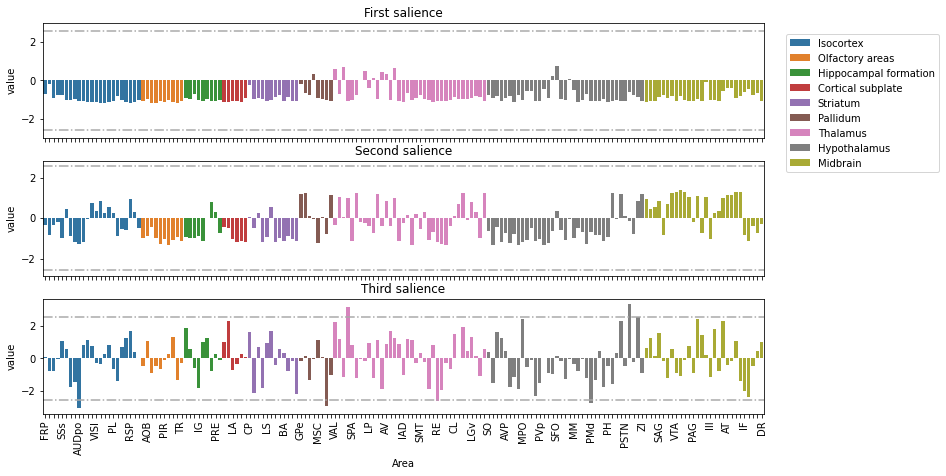

In [57]:
upls.plot_panel_contrasts(batch=batch, variable='density')
upls.plot_panel_saliences(batch=batch, variable='density', df_levels=df_levels)

# PLS relative density

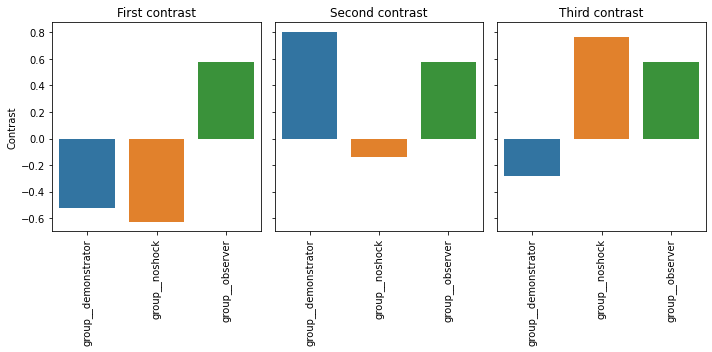

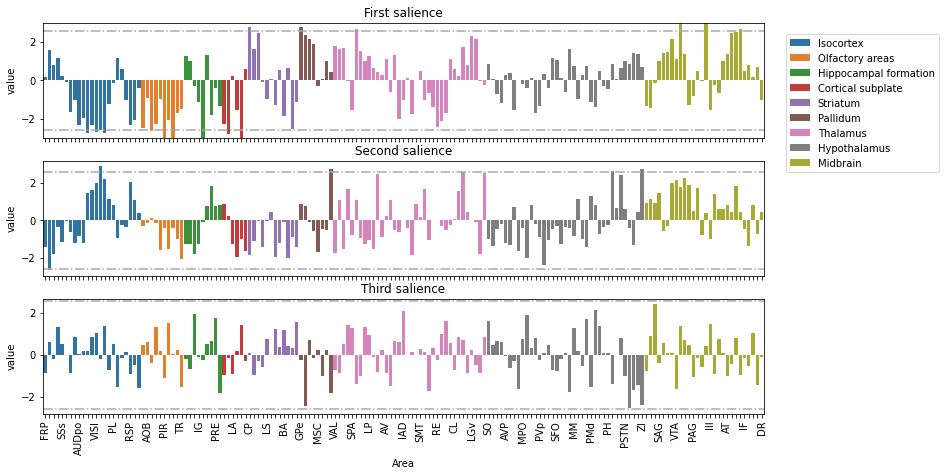

In [58]:
upls.plot_panel_contrasts(batch=batch, variable='relative_density')
upls.plot_panel_saliences(batch=batch, variable='relative_density', df_levels=df_levels)

# Identify areas with significant area contribution

In [68]:
batch='PISA'
overlap = {'ncells':[], 'energy':[], 'density':[], 'relative_density':[]}
for variable in overlap.keys():
    overlap[variable] = set(upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=1.96, 
                                           volumes=volumes))
[len(overlap[key]) for key in overlap.keys()]

[19, 20, 18, 55]

In [71]:
overlap['relative_density']

{'Anterior olfactory nucleus',
 'Anterolateral visual area',
 'Anteromedial visual area',
 'Basomedial amygdalar nucleus',
 'Bed nucleus of the anterior commissure',
 'Caudoputamen',
 'Central amygdalar nucleus',
 'Claustrum',
 'Cortical amygdalar area',
 'Endopiriform nucleus',
 'Entorhinal area',
 'Fundus of striatum',
 'Globus pallidus external segment',
 'Globus pallidus internal segment',
 'Interanterodorsal nucleus of the thalamus',
 'Interanteromedial nucleus of the thalamus',
 'Intercalated amygdalar nucleus',
 'Lateral habenula',
 'Lateral hypothalamic area',
 'Lateral terminal nucleus of the accessory optic tract',
 'Lateral visual area',
 'Main olfactory bulb',
 'Midbrain reticular nucleus',
 'Midbrain reticular nucleus retrorubral area',
 'Nucleus of reuniens',
 'Nucleus of the brachium of the inferior colliculus',
 'Nucleus of the lateral olfactory tract',
 'Pedunculopontine nucleus',
 'Peripeduncular nucleus',
 'Periventricular hypothalamic nucleus preoptic part',
 'Pirif

In [72]:
[volumes[volumes['safe_name']==area]['acronym'].values[0] for area in overlap['relative_density']]

['LHA',
 'MOB',
 'SubG',
 'BAC',
 'PVpo',
 'TT',
 'RR',
 'TR',
 'LGv',
 'VISpl',
 'RT',
 'AUDv',
 'SI',
 'NB',
 'COA',
 'VISam',
 'RN',
 'AON',
 'GPe',
 'RCH',
 'FS',
 'VISal',
 'CLA',
 'RH',
 'POL',
 'SNc',
 'PST',
 'EP',
 'IA',
 'ENT',
 'BMA',
 'ZI',
 'RSP',
 'CEA',
 'MRN',
 'LT',
 'GPi',
 'VISl',
 'NLOT',
 'RE',
 'MOp',
 'SNr',
 'IAD',
 'CP',
 'PPN',
 'VISrl',
 'OV',
 'PMv',
 'PIR',
 'AUDpo',
 'IAM',
 'LH',
 'VTA',
 'PP',
 'VISp']